In [1]:
import os
import random
import re
import numpy as np
import shutil
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Optional
from pathlib import Path
import logging
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context("talk")
sns.set_theme(font = 'serif')

In [3]:
data_folder = ["output_19_01_2025/", "output_21_03_2025/"]
folder_path_outputs = '/app/nse/outputs/'
file_path_results = '/app/nse/results/'

In [4]:
def read_data(filename):
    with open(filename, 'r') as file:
        # Skip the first three lines
        for _ in range(3):
            next(file)
        
        # Read the rest of the file
        data = np.loadtxt(file)
    
    return data

In [5]:
def get_folder_paths(folder_path, folder_pattern):
    folder_list = [folder_path + f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and re.search(folder_pattern, f)]
    folder_list.sort(key=os.path.getctime)
    return folder_list

In [6]:
def extract_number(filename):
    match = re.search(r'C\[(\d+)\]-avg-\.plt', filename)
    return int(match.group(1)) if match else float('inf') 

In [7]:
def sort_filenames(filenames):
    return sorted(filenames, key=extract_number)

In [8]:
def get_filenames(file_path, file_pattern):
    file_list = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f)) and re.search(file_pattern, f)]
    file_list = sort_filenames(file_list)
    return file_list

In [9]:
outputs_folder_names = []
for folder in data_folder:
    outputs_folder_names.extend(get_folder_paths(folder_path_outputs + folder, "output*"))

In [10]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [11]:
@dataclass
class PhysData:
    """Data class for storing physics parameters."""
    hbl: np.ndarray
    U_star: np.ndarray
    theta_star: np.ndarray
    time: np.ndarray
@dataclass
class PhysDataMean:
    hbl: float
    U_star: float
    
class PhysParser:
    
    def __init__(self, phys_path: str):
        self.phys_path = Path(phys_path)
        self.phys_text = None
        self.phys_data = None

    def read_config(self) -> None:
        try:
            with open(self.phys_path, 'r') as file:
                for _ in range(3):
                    next(file)
                # Read the rest of the file
                self.phys_text = np.loadtxt(file)
            logger.info(f"Successfully read configuration file: {self.phys_path}")
        except FileNotFoundError:
            logger.error(f"Phys file not found: {self.phys_path}")
            raise
        except Exception as e:
            logger.error(f"Error reading Phys file: {e}")
            raise
    def parse(self) -> PhysData:
            if not self.phys_text:
                self.read_config()

            try:
                # Extract main configuration values
                hbl = self.phys_text[:, 9]
                U_star = self.phys_text[:, 3]
                theta_star = self.phys_text[:, 4]
                time = self.phys_text[:, 0]
                
                self.phys_data = PhysData(hbl, U_star, theta_star, time)
                logger.info("Successfully parsed configuration data")
                
                return self.phys_data
                
            except Exception as e:
                logger.error(f"Error parsing configuration: {e}")
                raise

In [12]:
@dataclass
class TracerData:
    """Data class for storing tracer-specific information."""
    index: int
    y_pos: float
    z_pos: float
    value: float

@dataclass
class ConfigData:
    """Data class for storing configuration parameters."""
    U: float
    z0_m: float
    surface_value: float
    grad_z: float
    value:float
    tracers: List[TracerData]


class ConfigParser:
    
    def __init__(self, config_path: str):
        self.config_path = Path(config_path)
        self.config_text = None
        self.config_data = None

    def read_config(self) -> None:
        try:
            with open(self.config_path, 'r') as f:
                self.config_text = f.read()
            logger.info(f"Successfully read configuration file: {self.config_path}")
        except FileNotFoundError:
            logger.error(f"Configuration file not found: {self.config_path}")
            raise
        except Exception as e:
            logger.error(f"Error reading configuration file: {e}")
            raise

    def _extract_float_value(self, pattern: str) -> float:
        match = re.search(pattern, self.config_text)
        if not match:
            raise ValueError(f"Could not find value matching pattern: {pattern}")
        return float(match.group(1))

    def _parse_tracers(self) -> List[TracerData]:
        tracers = []
        tracer_sections = re.finditer(
            r'tracer_(\d+)\s*{[^}]*}\s*#[^]]*]\s*point_emission\s*{([^}]*)}', 
            self.config_text
        )
        
        for section in tracer_sections:
            index = int(section.group(1))
            tracer_text = section.group(2)
            
            try:
                value = float(re.search(r'value\s*=\s*([0-9.]+)', tracer_text).group(1))
                y_pos = float(re.search(r'ypos\s*=\s*[^+]*\+\s*([0-9.]+)', tracer_text).group(1))
                z_pos = float(re.search(r'zpos\s*=\s*([0-9.]+)', tracer_text).group(1))
                
                tracers.append(TracerData(index, y_pos, z_pos, value))
            except Exception as e:
                logger.error(f"Error parsing tracer {index}: {e}")
                raise
                
        return sorted(tracers, key=lambda x: x.index)

    def parse(self) -> ConfigData:
        if not self.config_text:
            self.read_config()

        try:
            # Extract main configuration values
            U = self._extract_float_value(r'U\s*=\s*([0-9.]+)')
            z0_m = self._extract_float_value(r'z0_m\s*=\s*([0-9.]+)')
            surface_value = self._extract_float_value(r'surface_value\s*=\s*([0-9.]+)')
            grad_z = self._extract_float_value(r'grad_z\s*=\s*([0-9.]+)')
            value = self._extract_float_value(r'value\s*=\s*(-[0-9.]+);	# sensible heat flux')
            # Parse tracer data
            tracers = self._parse_tracers()
            
            
            self.config_data = ConfigData(U, z0_m, surface_value, grad_z, value, tracers)
            logger.info("Successfully parsed configuration data")
            
            return self.config_data
            
        except Exception as e:
            logger.error(f"Error parsing configuration: {e}")
            raise

class DataAnalyzer:
    
    def __init__(self, config_data: ConfigData, phys_data: PhysDataMean):
        self.config_data = config_data
        self.phys_data = phys_data
    def create_dataframe(self) -> pd.DataFrame:
        data = []
        
        # Create rows for each tracer
        for tracer in self.config_data.tracers:
            row = {
                'Tracer': tracer.index,
                # 'y': tracer.y_pos,
                'z': tracer.z_pos,
                # 'u': self.config_data.U,
                # 'power': tracer.value,
                # 'roughness': self.config_data.z0_m,
                # 'T': self.config_data.surface_value,
                'sensible_heat_flux':self.config_data.value,
                # 'T_grad': self.config_data.grad_z
                'hbl':self.phys_data.hbl,
                'U_star':self.phys_data.U_star
            }
            data.append(row)
            
        return pd.DataFrame(data)

    def save_to_csv(self, output_path: str) -> None:
        df = self.create_dataframe()
        df.to_csv(output_path, index=False)
        logger.info(f"Data saved to: {output_path}")

In [13]:
def plot_phys_description(data: pd.DataFrame,avg_time: float, save_path: str = "./"):
    
    
    # sns.set_theme(style="whitegrid")
    shape_col_t = 2        
    shape_row_t = 2
    fig, axes = plt.subplots(shape_row_t, shape_col_t, figsize=(10, 8)) 
    
    # sns.set(font_scale=1.5, rc={'text.usetex' : True})
    # plt.rcParams.update({
    #     "text.usetex": True,
    #     "font.family": "sans-serif",
    #     "font.sans-serif": "Helvetica",
    # })
    plt.style.use('seaborn-v0_8-white')

    sns.set_theme(font_scale=1.9)
    sns.histplot(data["velocity_ratio"], ax=axes[0, 0], bins = 50)
    axes[0, 0].set_title(f'u*/w*', fontsize=32)
    axes[0, 0].set(xlabel=None, ylabel=None)

    
    sns.histplot(data["w_star"], ax=axes[0, 1], bins = 50)
    axes[0, 1].set_title(f'$|u_g|$/w*', fontsize=32)
    axes[0, 1].set(xlabel=None, ylabel=None)

    
    sns.histplot(data["h_star"], ax=axes[1, 0], bins = 50)
    axes[1, 0].set_title(f'$z_p$/h', fontsize=32)
    axes[1, 0].set(xlabel=None, ylabel=None)

    sns.histplot(avg_time/data["time_star"], ax=axes[1, 1], bins = 50)
    axes[1, 1].ticklabel_format(style='scientific', axis='x', scilimits=[-3, 4])
    axes[1, 1].set_title(r'$t_{avg}$/t*', fontsize=32)
    axes[1, 1].set(xlabel=None, ylabel=None)
    plt.tight_layout(h_pad = 1.5)
    
    plt.savefig(save_path + "phys_description.png", dpi=300)

In [14]:
def preprocess_data(data: PhysData, avg_time: float):
    n = data.hbl.shape[0]
    start_idx = int(n*(1-avg_time))
    hbl_mean = np.mean(data.hbl[start_idx:])
    U_star_mean = np.mean(data.U_star[start_idx:])
    return hbl_mean, U_star_mean

In [15]:
beta = 9.81/243.0
avg_time = 0.2 * 3600

In [36]:
features_all = pd.DataFrame()
wind_u_l = []
for folder in outputs_folder_names:
    config_path = folder + "/config.txt"
    parser = ConfigParser(config_path)
    features = parser.parse()

    phys_path = folder + "/series/" + "phys.plt"
    # phys_path = folder + "/stat-1d/" + "Theta-avg-.plt"
    phys_path_wind = folder + "/stat-1d/" + "Wind-avg-.plt"

    parser = PhysParser(phys_path)
    parser_wind = PhysParser(phys_path_wind)
    
    physics_v = parser.parse()
    physics_wind = parser_wind.read_config()
    wind_u = parser_wind.phys_text[-1,1]

    physics_v_mean = PhysDataMean(*preprocess_data(physics_v, avg_time))
    
    wind_u_l.extend([wind_u] * 64)

    analyzer = DataAnalyzer(features, physics_v_mean)
    features_pd = analyzer.create_dataframe()
    features_all = pd.concat([features_all, features_pd], axis=0)

2025-03-31 07:06:03,023 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_15_14_17/config.txt
2025-03-31 07:06:03,024 - INFO - Successfully parsed configuration data
2025-03-31 07:06:03,028 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_15_14_17/series/phys.plt
2025-03-31 07:06:03,028 - INFO - Successfully parsed configuration data
2025-03-31 07:06:03,029 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_15_14_17/stat-1d/Wind-avg-.plt
2025-03-31 07:06:03,030 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_16_2_9/config.txt
2025-03-31 07:06:03,031 - INFO - Successfully parsed configuration data
2025-03-31 07:06:03,035 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_16_2_9/series/phys.plt
2025-03-31 07:06:03,035 - INFO - Successfully parsed

In [37]:
features_all["h_star"] = features_all["z"] / features_all["hbl"]  
features_all["w_star"] = (beta*features_all["sensible_heat_flux"].abs() * features_all["hbl"])**(1/3.0)
features_all["time_star"] = features_all["hbl"] / features_all["w_star"]  
features_all["velocity_ratio"] = features_all["U_star"] / features_all["w_star"]
features_all["w_star"] = np.array(wind_u_l) / features_all["w_star"] 

In [38]:
features_all.to_csv("phys_description.csv", index=False)

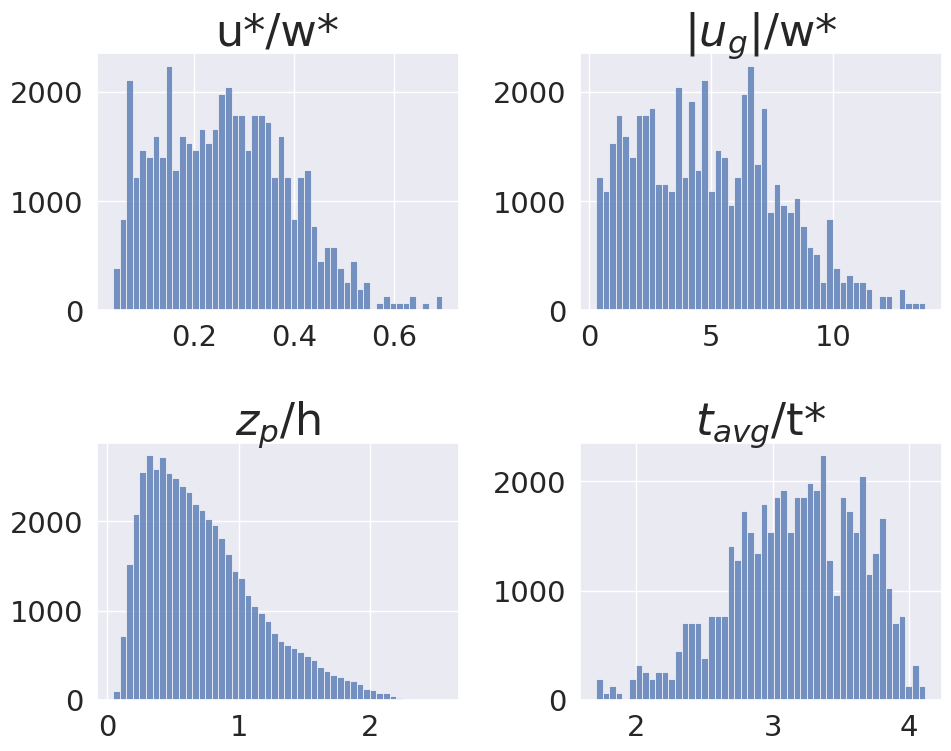

In [39]:
plot_phys_description(features_all, avg_time)

2025-03-31 13:54:12,175 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_15_14_17/config.txt
2025-03-31 13:54:12,177 - INFO - Successfully parsed configuration data
2025-03-31 13:54:12,301 - INFO - Successfully read configuration file: /app/nse/outputs/output_19_01_2025/output_2025_2_10_15_14_17/stat-1d/Theta-avg-.plt


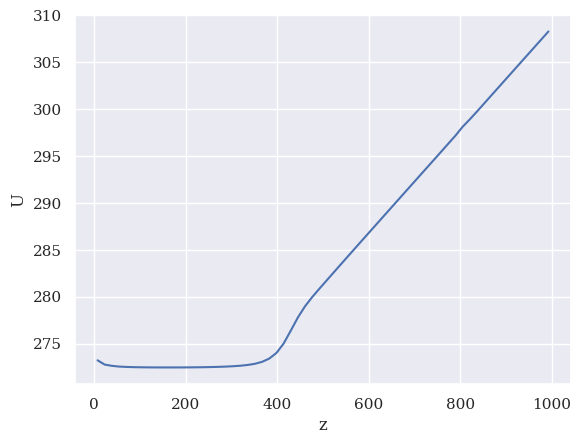

In [16]:
features_all = pd.DataFrame()
for folder in outputs_folder_names[:1]:
    config_path = folder + "/config.txt"
    parser = ConfigParser(config_path)
    features = parser.parse()

    # phys_path = folder + "/series/" + "phys.plt"
    # phys_path = folder + "/stat-1d/" + "U-avg-.plt"
    # phys_path1 = folder + "/stat-1d/" + "V-avg-.plt"
    # phys_path2 = folder + "/stat-1d/" + "Wind-avg-.plt"
    phys_path3 = folder + "/stat-1d/" + "Theta-avg-.plt"


    
    # parser = PhysParser(phys_path)
    # parser1 = PhysParser(phys_path1)
    # parser2 = PhysParser(phys_path2)
    parser3 = PhysParser(phys_path3)



    # data = parser.read_config()
    # data1 = parser1.read_config()
    # data2 = parser2.read_config()
    data3 = parser3.read_config()


    # print(parser2.phys_text[-1, 1])
    # plt.plot(parser.phys_text[:, 0], np.sqrt(parser.phys_text[:, 1]**2 + parser1.phys_text[:, 1]**2)/parser2.phys_text[-1, 1])
    plt.plot(parser3.phys_text[:, 0], parser3.phys_text[:, 1])
    plt.xlabel("z")
    plt.ylabel("U")

    # physics_v = parser.parse()
    # physics_v_mean = PhysDataMean(*preprocess_data(physics_v, avg_time))
    
    # analyzer = DataAnalyzer(features, physics_v_mean)
    # features_pd = analyzer.create_dataframe()
    # features_all = pd.concat([features_all, features_pd], axis=0)